The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


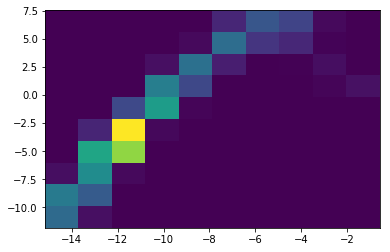

In [39]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "..")))
import numpy as np
from itertools import islice
import matplotlib.pyplot as plt
from keras import backend as K

from pysgmcmc.samplers.sghmc import SGHMCSampler
from pysgmcmc.samplers.relativistic_sghmc import RelativisticSGHMCSampler
from pysgmcmc.samplers.sgld import SGLDSampler

from pysgmcmc.samplers.energy_functions import (
    banana_log_likelihood, gmm1_log_likelihood, gmm2_log_likelihood, gmm3_log_likelihood,
    to_negative_log_likelihood
)


ENERGY_FUNCTIONS = {
    "banana": (
        banana_log_likelihood,
        lambda: [K.random_normal_variable(shape=(1,), mean=0., scale=1.,), K.random_normal_variable(shape=(1,), mean=0., scale=1.,)],
        lambda samples: plt.hist2d(samples[:, 0], samples[:, 1]),
        None
    ),
    "gmm1": (
        gmm1_log_likelihood,
        lambda: [K.variable(K.random_normal((1,)))],
        plt.hist,
        None
    )
}

SAMPLERS = (
    SGHMCSampler, RelativisticSGHMCSampler, SGLDSampler
)


def sample(sampler, n_samples=10**5, burn_in_steps=0, keep_every=1):
    _ = list(islice(sampler, burn_in_steps))
    return np.asarray([sample for _, sample in islice(sampler, keep_every, n_samples * keep_every + keep_every)])


energy_function, initial_guess, plot_samples, plot_function = ENERGY_FUNCTIONS["banana"]

for sampler in SAMPLERS[:1]:
    initial_sample = initial_guess()
    loss = to_negative_log_likelihood(energy_function)(initial_sample)
    samples = np.squeeze(sample(sampler(loss=loss, params=initial_sample, lr=0.01, burn_in_steps=3000)))
    plot_samples(samples)
    plt.show()